**Let's recall incremental learning step from tabular Q-learning.**
$$\hat{q}(x,u) \leftarrow \hat{q}(x,u) + \alpha * [r + \gamma * max_u \hat{q}(x',u') - \hat{q}(x,u)]$$

**Deep Q network (DQN) transform this to an approximate solution:**
Objective function, $$J(\bold{w}) = \mathbb{E}_{\pi}[q_{\pi}(x,u) - \hat{q}(x, u, \bold{w})]^2$$
$$\nabla{w} = -\frac{\alpha}{2} \nabla{J(\bold{w})}$$
$$w \leftarrow w+ \alpha [q_{\pi}(x,u) - \hat{q}(x, u, \bold{w})]*\nabla{\hat{q}(x, u, \bold{w})}$$

**Depending on the control approach, the true target $q_{\pi}(x,u)$ is approximated by:**
* monte carlo: full episodic return, $q_{\pi}(x_k,u) \simeq G_k$
* SARSA: one-step bootstrapped estimate, $q_{\pi}(x_k,u) \simeq r_{k+1} + \gamma*\hat{q}(x_{k+1},u_{k+1},\bold{w})$
* Q-learning: one-step bootstrapped estimate, $q_{\pi}(x_k,u) \simeq r_{k+1} + \gamma* max_u\hat{q}(x_{k+1},u,\bold{w})$

![](Images/DQN.png)

In [6]:
import numpy as np
import os
import math
import random
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
import gymnasium as gym

class Q_Network(tf.keras.Model):
    def __init__(self, action_space, fc1_dims=128, fc2_dims=128):
        super(Q_Network, self).__init__() # The purpose of this line is to ensure that the constructor(__init__()) of the parent class (tf.keras.Model) is executed before the additional initialization specific to the CriticNetwork class. 
        self.layer_one_neurons = fc1_dims
        self.layer_two_neurons = fc2_dims
        
        self.first_layer = Dense(self.layer_one_neurons, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3))
        self.second_layer = Dense(self.layer_two_neurons, activation='relu', kernel_initializer=tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3))
        self.third_layer = Dense(action_space, activation=None)

    def call(self, state):
        q_value = self.first_layer(state)
        q_value = self.second_layer(q_value)
        q_value = self.third_layer(q_value)
        return q_value

In [7]:
alpha = 0.0005
gamma = 0.99
nb_episodes = 400  # we have to train it for more no of episodes as we have two networks
mini_batch_size = 64  # size of mini-batches
action_space = 3
memory_size = 1000000  # capacity of buffer memory

LAMBDA = 0.001  # speed of decay
epsilon = 1.0
MIN_EPSILON = 0.01

env =  gym.make('MountainCar-v0')
state = env.reset()[0]

# define ANN topology
q_network = Q_Network(action_space, fc1_dims=512, fc2_dims=256)

opt = SGD(learning_rate=alpha)  # giving learning rate (α)
mse = tf.keras.losses.MeanSquaredError()
q_network.compile(optimizer=opt, loss="mean_squared_error")

# Target Network
target_network = Q_Network(action_space, fc1_dims=512, fc2_dims=256)

# # Initially set equal weights
target_network.set_weights(q_network.get_weights())  # simple copy weights

# buffer memory 
state_memory = np.zeros((memory_size,len(state)),dtype=np.float32)
action_memory = np.zeros(memory_size,dtype=np.int32)
reward_memory = np.zeros(memory_size,dtype=np.float32)
next_state_memory = np.zeros((memory_size,len(state)),dtype=np.float32)
terminal_memory = np.zeros(memory_size,dtype=np.int32)

current_memory_count = 0 

batch_index = np.arange(mini_batch_size, dtype=np.int32)

reward_history = []
avg_reward_history = []
q_loss_history = []

best_reward = env.reward_range[0]

directory_name = os.path.join(os.getcwd(), 'Model/DQN/')

for j in range(nb_episodes): 
    steps = 0
    state = env.reset()[0]
    reward_per_episode = 0
    
    while True:
        # choose action using ε-greedy policy
        non_greedy_prob = epsilon/3  # Probability of all non-greedy action
        greedy_prob = 1 - epsilon + non_greedy_prob  # Probability of all greedy action

        greedy_action = np.argmax(q_network.call(tf.convert_to_tensor([state], dtype=tf.float32)))
        weight_vector = non_greedy_prob*np.ones((action_space))  # The weights of all non-greedy actions are equal to non-greedy probability
        weight_vector[greedy_action] = greedy_prob  # Now, we replace the weight of our greedy-action with greedy probability

        action = np.random.choice(action_space,1,p=weight_vector)[0]

        next_state,reward,done,_,_ = env.step(action)

        reward_per_episode += reward

        idx = current_memory_count % memory_size 
        state_memory[idx] = state  # store up till max memory_size then start replacing from 0th index
        action_memory[idx] = action  # store up till max memory_size then start replacing from 0th index
        reward_memory[idx] = reward  # store up till max memory_size then start replacing from 0th index
        next_state_memory[idx] = next_state  # store up till max memory_size then start replacing from 0th index
        terminal_memory[idx] = 1 - int(done)  # store up till max memory_size then start replacing from 0th index
        
        state = next_state # update states
        
        # once buffer memory size is greater then equal to mini-batch size, then use target-network for target prediction
        if current_memory_count >= mini_batch_size: # learning_starts at 64
            mini_batch = np.random.choice(min(current_memory_count,memory_size),mini_batch_size,replace=False) # randomly sample mini-batch
            
            # sample data from buffer memory numpy arrays and converting it into tensorflow tensors
            state_vector = tf.convert_to_tensor(state_memory[mini_batch], dtype=tf.float32)
            action_vector = action_memory[mini_batch]
            reward_vector = tf.convert_to_tensor(reward_memory[mini_batch], dtype=tf.float32)
            next_state_vector = tf.convert_to_tensor(next_state_memory[mini_batch], dtype=tf.float32)
            done_vector = terminal_memory[mini_batch]  # we'll get 0 for terminal state and 1 for all other states

            with tf.GradientTape() as tape:
                tape.watch(q_network.trainable_variables) # watch() is used to start tracing Tensor by the Tape

                q_val = q_network.call(state_vector)

                q_values = tf.reduce_sum(q_val * tf.one_hot(action_vector,action_space), axis=1)  # (64,1)

                # Initially set equal weights
                if current_memory_count == mini_batch_size:  
                    target_network.call(next_state_vector)
                    target_network.set_weights(q_network.get_weights())  # simple copy weights

                target_val = target_network.call(next_state_vector)

                target = reward_vector + gamma*tf.math.reduce_max(target_val,axis=1)*done_vector  # (64,1)

                q_loss = tf.keras.losses.MSE(target, q_values)  # L(W) = Σ[r_{i+1} + γ.max(q(x_{i+1},u,W)) - q(x_{i},u_{i},W)]^2/n
                q_network_gradient = tape.gradient(q_loss,q_network.trainable_variables)  # gradient of cost function -> ∇L(W)
                q_network.optimizer.apply_gradients(zip(q_network_gradient,q_network.trainable_variables)) # update weight vector using ADAMS, W_{i+1} = W_{i} - α.∇L(W)

            q_loss_history.append(q_loss.numpy())  # storing Q-value loss function
       
            # reduce epsilon value 
            if epsilon > MIN_EPSILON:
                epsilon = epsilon - LAMBDA
            else:
                epsilon = MIN_EPSILON

            # update target_network weights after 2000 steps
            if current_memory_count % 1000 == 0: 
                target_network.set_weights(q_network.get_weights()) 
        
        steps += 1
        current_memory_count += 1 
       
        if done:
            print("Reward for",j,"episode and",steps,"steps")
            reward_history.append(reward_per_episode)   
            avg_reward = np.mean(reward_history[-100:])
            avg_reward_history.append(avg_reward) 
            
            if avg_reward > best_reward:
                best_reward = avg_reward
                q_network.save_weights(os.path.join(directory_name,'q_network_weights.h5'))
                target_network.save_weights(os.path.join(directory_name,'target_network_weights.h5'))
            
            break # start new episode     
                
# Save the state data as ".csv" for plotting
with open(os.path.join(directory_name,"model_1_data.csv"),'w') as csvfile:  
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows([reward_history])
    csvwriter.writerows([avg_reward_history])
    csvwriter.writerows([q_loss_history])

Reward for 0 episode and 1015 steps
Reward for 1 episode and 569 steps
Reward for 2 episode and 1709 steps
Reward for 3 episode and 3764 steps
Reward for 4 episode and 2008 steps
Reward for 5 episode and 1981 steps
Reward for 6 episode and 2007 steps
Reward for 7 episode and 2179 steps
Reward for 8 episode and 1806 steps
Reward for 9 episode and 5198 steps
Reward for 10 episode and 2456 steps
Reward for 11 episode and 152 steps
Reward for 12 episode and 1201 steps
Reward for 13 episode and 267 steps
Reward for 14 episode and 388 steps
Reward for 15 episode and 130 steps
Reward for 16 episode and 488 steps
Reward for 17 episode and 490 steps
Reward for 18 episode and 566 steps
Reward for 19 episode and 522 steps
Reward for 20 episode and 607 steps
Reward for 21 episode and 103 steps
Reward for 22 episode and 463 steps
Reward for 23 episode and 625 steps
Reward for 24 episode and 726 steps
Reward for 25 episode and 244 steps
Reward for 26 episode and 355 steps
Reward for 27 episode and 5

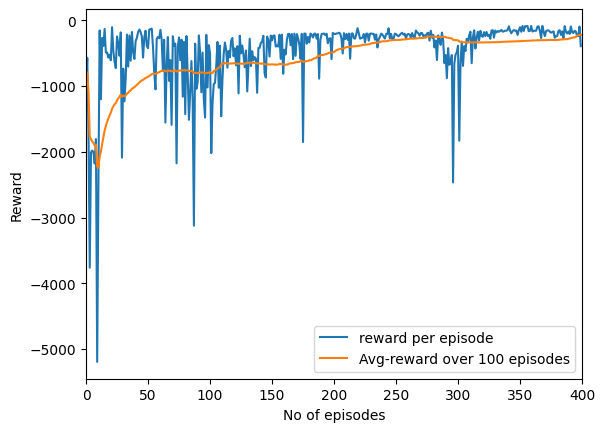

In [9]:
## PLOT TRAINING RESULTS

import numpy as np
import matplotlib.pyplot as plt
import csv
import os

directory_name = os.path.join(os.getcwd(), 'Model/DQN/')

# opening the CSV file
with open(os.path.join(directory_name,"model_1_data.csv"), mode ='r') as file:
  csvFile = csv.reader(file)
  Pendulum_data = list(csvFile)

plt.figure(1)
plt.plot(range(len(Pendulum_data[0])),list(map(float, Pendulum_data[0])),label ='reward per episode')
plt.plot(range(len(Pendulum_data[1])),list(map(float, Pendulum_data[1])),label ='Avg-reward over 100 episodes')
plt.xlabel('No of episodes')
plt.ylabel('Reward')
plt.xlim([0, len(Pendulum_data[1])])
plt.legend()

In [11]:
import numpy as np
import gymnasium as gym
import os

directory_name = os.path.join(os.getcwd(), 'Model/DQN/')

env = gym.make('MountainCar-v0', render_mode="human")
state = np.array([env.reset()[0]])

# define ANN topology
DQN_model = Q_Network(3, fc1_dims=512, fc2_dims=256)

DQN_model.build(input_shape=state.shape)

DQN_model.load_weights(os.path.join(directory_name,"q_network_weights.h5"))

while True:
    q_values = DQN_model(state)
    action = np.argmax(np.array(q_values)[0])
    state, reward, done, _, _ = env.step(action)
    state = np.array([state])
    if done:
        break
env.close()